In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import spacy
import datasets
from datasets import Dataset, DatasetDict, load_dataset
import torchtext
import tqdm
import evaluate
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using", device, "device")
from transformers import MarianTokenizer 
spacy.prefer_gpu() # require_gpu raises an error if no GPU is avail 
nlp = spacy.load("en_core_web_md")
import re
import unicodedata
import jieba

Using cuda device


Adapted from "https://github.com/bentrevett/pytorch-seq2seq/blob/main/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb"

In [50]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [51]:
dataset = load_dataset("iwslt2017", "iwslt2017-en-zh")
train_data, valid_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"],
)
train_data

Dataset({
    features: ['translation'],
    num_rows: 231266
})

In [52]:
train_data_backup = train_data

In [53]:

train_data = train_data.select(range(10000))
train_data

Dataset({
    features: ['translation'],
    num_rows: 10000
})

## Tokenizers Spacy & Jieba

In [54]:
def tokenize_pair(pair, max_length, sos_token, eos_token):
    en_tokens = [token.text for token in nlp.tokenizer(pair['translation']['en'])][:max_length]
    zh_tokens = list(jieba.cut(pair['translation']['zh'], cut_all=False))[:max_length] # if cut_all is True, it will use the full mode. Default is accurate mode.
    en_tokens = [sos_token] + en_tokens +  [eos_token]
    zh_tokens = [sos_token] + zh_tokens +  [eos_token]
    return {"en_tokens": en_tokens, "zh_tokens": zh_tokens}

In [55]:
# max lengths from eda 
max_length_g = 249 # max of en and zh 
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "max_length":max_length_g,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_pair, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_pair, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_pair, fn_kwargs=fn_kwargs)

train_data

Map: 100%|██████████| 8549/8549 [00:02<00:00, 3741.80 examples/s]


Dataset({
    features: ['translation', 'en_tokens', 'zh_tokens'],
    num_rows: 10000
})

In [56]:
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

zh_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["zh_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [70]:
zh_vocab.get_itos()[:10] 

['<unk>', '<pad>', '<sos>', '<eos>', '的', ' ', '，', '。', '我', '是']

In [58]:
assert en_vocab[unk_token] == zh_vocab[unk_token]
assert en_vocab[pad_token] == zh_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

en_vocab.set_default_index(unk_index)
zh_vocab.set_default_index(unk_index)

In [59]:
en_vocab[pad_token]

1

In [60]:
def numericalize_example(example, en_vocab, zh_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    zh_ids = zh_vocab.lookup_indices(example["zh_tokens"])
    return {"en_ids": en_ids, "zh_ids": zh_ids}

In [61]:
fn_kwargs = {"en_vocab": en_vocab, "zh_vocab": zh_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

Map: 100%|██████████| 8549/8549 [00:00<00:00, 9393.73 examples/s]


In [62]:
train_data[0]['en_ids'][0] ,  train_data[0]['en_ids'][-1] , train_data[0]['zh_ids'][0] ,  train_data[0]['zh_ids'][-1]

(2, 3, 2, 3)

In [63]:
data_type = "torch"
format_columns = ["en_ids", "zh_ids"]

train_data = train_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

In [64]:
type(train_data[0]['zh_ids']) , train_data[0]['zh_ids']

(torch.Tensor,
 tensor([   2,   72,  389,    6,  973,    7,  722,   72, 3468,    5,   53,   17,
         5259,  561,   11,   21, 3182,    4,  322,    6,    8,  892,    0,    7,
            3]))

In [65]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_zh_ids = [example["zh_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_zh_ids = nn.utils.rnn.pad_sequence(batch_zh_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "zh_ids": batch_zh_ids,
        }
        return batch

    return collate_fn

In [66]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [67]:
batch_size = 128

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [68]:
class Encoder(nn.Module):
    def __init__(
        self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout
    ):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional=False)
        self.fc = nn.Linear(encoder_hidden_dim, decoder_hidden_dim) # encoder_hidden  * 2 if bidirectional!
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [src length, batch size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src length, batch size, embedding dim]
        outputs, hidden = self.rnn(embedded)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        # outputs are always from the last layer
        # hidden [-2, :, : ] is the last of the forwards RNN
        # hidden [-1, :, : ] is the last of the backwards RNN
        # initial decoder hidden is final hidden state of the forwards and backwards
        # encoder RNNs fed through a linear layer
        # hidden = torch.tanh(
        #     self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        # )
        hidden = torch.tanh(self.fc(hidden[-1, :, :]))
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        return outputs, hidden

In [25]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim) + decoder_hidden_dim, decoder_hidden_dim # IF BIDIRECTIONAL MUST encoder_hidden_dim * 2 
        )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden = [batch size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]
        # repeat decoder hidden state src_length times
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # hidden = [batch size, src length, decoder hidden dim]
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))
        # energy = [batch size, src length, decoder hidden dim]
        attention = self.v_fc(energy).squeeze(2)
        # attention = [batch size, src length]
        return torch.softmax(attention, dim=1)

In [26]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        dropout,
        attention,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim) + embedding_dim, decoder_hidden_dim) # IF BIDIRECTIONAL MUST encoder_hidden_dim * 2 
        self.fc_out = nn.Linear(
            (encoder_hidden_dim) + decoder_hidden_dim + embedding_dim, output_dim # IF BIDIRECTIONAL MUST encoder_hidden_dim * 2 
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # input = [batch size]
        # hidden = [batch size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, embedding dim]
        a = self.attention(hidden, encoder_outputs)
        # a = [batch size, src length]
        a = a.unsqueeze(1)
        # a = [batch size, 1, src length]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        weighted = torch.bmm(a, encoder_outputs)
        # weighted = [batch size, 1, encoder hidden dim * 2]
        weighted = weighted.permute(1, 0, 2)
        # weighted = [1, batch size, encoder hidden dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim=2)
        # rnn_input = [1, batch size, (encoder hidden dim * 2) + embedding dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output = [seq length, batch size, decoder hid dim * n directions]
        # hidden = [n layers * n directions, batch size, decoder hid dim]
        # seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, decoder hidden dim]
        # hidden = [1, batch size, decoder hidden dim]
        # this also means that output == hidden
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        # prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [27]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, decoder hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

In [28]:
input_dim = len(en_vocab)
output_dim = len(zh_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
encoder_hidden_dim = 512
decoder_hidden_dim = 512
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    decoder_dropout,
    attention,
)

model = Seq2Seq(encoder, decoder, device).to(device)

In [29]:
def init_weights(m):
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7066, 256)
    (rnn): GRU(256, 512)
    (fc): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=1024, out_features=512, bias=True)
      (v_fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(8229, 256)
    (rnn): GRU(768, 512)
    (fc_out): Linear(in_features=1280, out_features=8229, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 18,396,709 trainable parameters


In [35]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [32]:
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(data_loader):
        src = batch["en_ids"].to(device)
        trg = batch["zh_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [33]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["en_ids"].to(device)
            trg = batch["zh_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [36]:
import os
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5
best_valid_loss = float("inf")
CHECKPOINT_DIR = "./model_checkpoints"
checkpoint_path = f"{CHECKPOINT_DIR}/model_checkpoint.pt"
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save({'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': best_valid_loss}, f"{CHECKPOINT_DIR}/model_checkpoint.pt")
        print(f"Checkpoint saved at epoch {epoch+1}")
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

 10%|█         | 1/10 [15:55<2:23:21, 955.74s/it]

Checkpoint saved at epoch 1
	Train Loss:   6.544 | Train PPL: 695.123
	Valid Loss:   5.881 | Valid PPL: 358.100


 20%|██        | 2/10 [35:48<2:26:02, 1095.28s/it]

	Train Loss:   6.016 | Train PPL: 410.093
	Valid Loss:   5.900 | Valid PPL: 364.948


 30%|███       | 3/10 [1:01:39<2:32:03, 1303.40s/it]

Checkpoint saved at epoch 3
	Train Loss:   5.870 | Train PPL: 354.359
	Valid Loss:   5.876 | Valid PPL: 356.253


 40%|████      | 4/10 [1:23:43<2:11:08, 1311.34s/it]

	Train Loss:   5.749 | Train PPL: 313.782
	Valid Loss:   5.884 | Valid PPL: 359.236


 50%|█████     | 5/10 [1:45:48<1:49:42, 1316.41s/it]

Checkpoint saved at epoch 5
	Train Loss:   5.650 | Train PPL: 284.271
	Valid Loss:   5.813 | Valid PPL: 334.547


 60%|██████    | 6/10 [2:08:44<1:29:06, 1336.58s/it]

	Train Loss:   5.558 | Train PPL: 259.368
	Valid Loss:   5.822 | Valid PPL: 337.768


 70%|███████   | 7/10 [2:31:08<1:06:56, 1338.92s/it]

Checkpoint saved at epoch 7
	Train Loss:   5.487 | Train PPL: 241.494
	Valid Loss:   5.801 | Valid PPL: 330.530


 80%|████████  | 8/10 [2:54:08<45:04, 1352.07s/it]  

Checkpoint saved at epoch 8
	Train Loss:   5.376 | Train PPL: 216.165
	Valid Loss:   5.787 | Valid PPL: 325.890


 90%|█████████ | 9/10 [3:16:18<22:25, 1345.30s/it]

	Train Loss:   5.254 | Train PPL: 191.348
	Valid Loss:   5.815 | Valid PPL: 335.382


100%|██████████| 10/10 [3:38:48<00:00, 1312.84s/it]

	Train Loss:   5.128 | Train PPL: 168.684
	Valid Loss:   5.802 | Valid PPL: 330.829


## Train from best state

In [37]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time % 60)
    return elapsed_mins, elapsed_secs

In [38]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time % 60)
    return elapsed_mins, elapsed_secs

patience = 2  
no_improvement_epochs = 0

if os.path.exists(checkpoint_path):
    print("Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_valid_loss = checkpoint['loss'] 
    print(f"Current best val loss : {best_valid_loss}")
else:
    print("Training started, no checkpoint found.")

for epoch in tqdm.tqdm(range(n_epochs)):
    start_time = time.time()
    train_loss = train_fn(model, train_data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device)
    valid_loss = evaluate_fn(model, valid_data_loader, criterion, device)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': best_valid_loss}, f"{CHECKPOINT_DIR}/model_checkpoint.pt")
        print(f"Checkpoint saved at epoch {epoch+1}")
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1
        
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Valid Loss: {valid_loss:.3f} | Valid PPL: {np.exp(valid_loss):7.3f}')
    # Auto stop
    if no_improvement_epochs >= patience:
        print(f"No improvement in val loss for {patience} consecutive epochs. Stopping training.")
        break
            
print("Training completed.")

Loading checkpoint...
Current best val loss : 5.78656142098563


 10%|█         | 1/10 [26:05<3:54:52, 1565.85s/it]

Epoch: 01 | Time: 26m 5s
	Train Loss: 5.268 | Train PPL: 194.093
	 Valid Loss: 5.795 | Valid PPL: 328.491


 10%|█         | 1/10 [52:22<7:51:20, 3142.26s/it]

Epoch: 02 | Time: 26m 16s
	Train Loss: 5.150 | Train PPL: 172.503
	 Valid Loss: 5.814 | Valid PPL: 335.026
No improvement in val loss for 2 consecutive epochs. Stopping training.
Training completed.


## Eval

In [36]:
checkpoint = torch.load(r"model_checkpoints\model_checkpoint.pt")
if 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])  
else:
    model.load_state_dict(checkpoint) 

test_loss = evaluate_fn(model, test_data_loader, criterion, device)
print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 5.609 | Test PPL: 272.876 |


In [71]:
def translate_sentence(
    sentence,
    model,
    en_vocab,
    zh_vocab,
    sos_token,
    eos_token,
    device,
    max_output_length=max_length_g,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            en_tokens =  [token.text for token in nlp.tokenizer(sentence)][:max_length_g]
        else:
            print('sentence is not an instance!')
        en_tokens = [sos_token] + en_tokens + [eos_token]
        ids = en_vocab.lookup_indices(en_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        encoder_outputs, hidden = model.encoder(tensor)
        inputs = zh_vocab.lookup_indices([sos_token])
        attentions = torch.zeros(max_output_length, 1, len(ids))
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(
                inputs_tensor, hidden, encoder_outputs
            )
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            if predicted_token not in [0,1,2,3]:
                inputs.append(predicted_token)
            
            if predicted_token == zh_vocab[eos_token]:
                break
        zh_tokens = zh_vocab.lookup_tokens(inputs[1:])
    return ''.join(zh_tokens), en_tokens, attentions[: len(zh_tokens) - 1]

In [72]:
zh_vocab.lookup_tokens([0,1,2,3,4])

['<unk>', '<pad>', '<sos>', '<eos>', '的']

In [73]:
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(10, 10))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

In [74]:
sentence = test_data[0]['translation']["en"]
expected_translation = test_data[0]['translation']["zh"]

sentence, expected_translation

('Several years ago here at TED, Peter Skillman  introduced a design challenge  called the marshmallow challenge.',
 '几年前，在TED大会上， Peter Skillman 介绍了一个设计挑战 叫做“棉花糖挑战”')

In [75]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_vocab,
    zh_vocab,
    sos_token,
    eos_token,
    device,
)
translation

'这是， '

In [76]:
sentence_tokens

['<sos>',
 'Several',
 'years',
 'ago',
 'here',
 'at',
 'TED',
 ',',
 'Peter',
 'Skillman',
 ' ',
 'introduced',
 'a',
 'design',
 'challenge',
 ' ',
 'called',
 'the',
 'marshmallow',
 'challenge',
 '.',
 '<eos>']

c:\Users\user\OneDrive\Documents\GitHub\cs4248-neural-translation\venvE3C\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\OneDrive\Documents\GitHub\cs4248-neural-translation\venvE3C\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


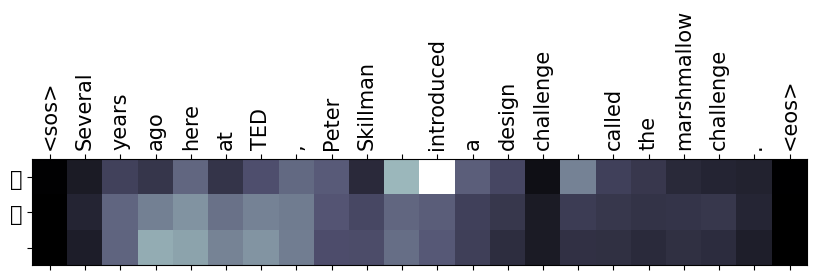

In [46]:
plot_attention(sentence_tokens, translation, attention)

In [77]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_vocab,
    zh_vocab,
    sos_token,
    eos_token,
    device,
)